# Reassigned spectrogram

In [1]:
import numpy as np
# import math
# from math import exp,pi
import matplotlib.pyplot as plt
# from scipy import signal 
# from scipy.signal import spectrogram, chirp
# from scipy.signal.windows import hann
# from obspy import Stream, Trace, UTCDateTime

from reassigned_spectogram import sine_sum_signal, chirp_signal, continuous_signal, nelson_reassigned

In [5]:
total_time = 200 #[sec]
dt = 0.01 #[sec]
time = np.arange(0,total_time, dt)

signal_ = sine_sum_signal(time, 3, 2, dt)
signal_ = chirp_signal(time, 1, 10, dt)


In [8]:
w_ = 5
fft_len_ = w_*8
overlap_ = 0.8
lim_amp = 1
F_S, Z_reassigned, CIF_1, LGD_1, freq, time_new = nelson_reassigned(signal_, w_, fft_len_, overlap_, 
                                                                    0, 20, lim_amp)

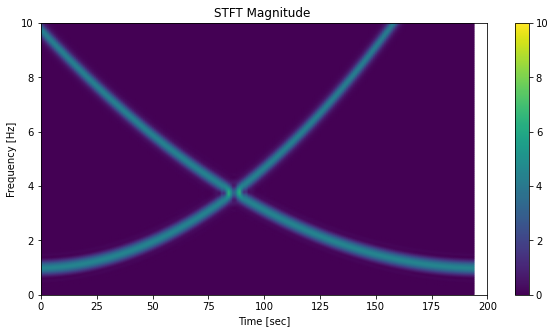

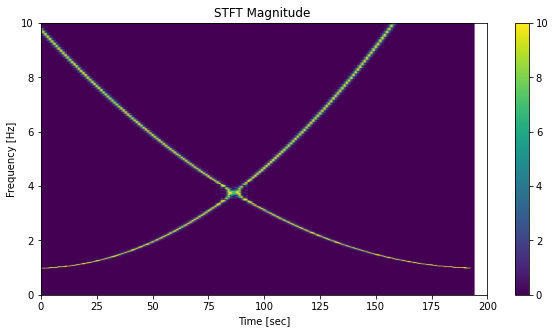

In [9]:
pos = 1500
amp = 1e1
XX = np.abs(F_S[:pos,:])
plt.figure(figsize=(10,5))
plt.pcolormesh(time_new,freq[:pos], XX, vmin=0, vmax=np.max(XX)/1, shading='gouraud')
plt.title('STFT Magnitude ')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,10)
plt.xlim([0,total_time])
plt.clim([0,amp])
plt.colorbar()
plt.show()

XX = np.abs(Z_reassigned[:pos,:])
plt.figure(figsize=(10,5))
plt.pcolormesh(time_new,freq[:pos], XX, vmin=0, vmax=np.max(XX)/1, shading='gouraud')
plt.title('STFT Magnitude ')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,10)
plt.xlim([0,total_time])
plt.clim([0,amp])
plt.colorbar()
plt.show()

In [ ]:
#-----------------------------------------------------------------------------------------------------------    
#----------------------------------------------------------------------------------------------------------- 

def get_stft(signal_, w_, fft_len_, overlap_):
    '''
    signal is a trace
    w_: window length
    fft_len: length of stft
    overlap_: window overlap
    '''
    if fft_len_/w_<4:
        fft_len_ = w_*4
        print('change fft length')
    dt = signal_.stats.delta
    fs = 1/dt
    window_s = int(fs*w_)
    window_s2 =window_s * 2
    n = np.arange(window_s)
    t_n = np.arange(-int(window_s/2), int(window_s/2))
    ovlp = int(overlap_*window_s) 
    dn = window_s - ovlp
    h = hann(window_s)
    
    fft_npts_ = np.int(fft_len_/dt)

    signal = signal_.data

    t_l = len(signal)
    time = np.arange(0,t_l*dt, dt)
    pos = np.arange(0, t_l-window_s, dn)
    time_new = time[pos]
    dt_new = time_new[1]
    pos_l = len(pos)

        
    freq = np.fft.fftfreq(fft_npts_, dt)
    S = np.zeros([fft_npts_, pos_l], dtype = np.complex64)
    S_del = np.zeros([fft_npts_, pos_l], dtype = np.complex64)

    norm_h = np.linalg.norm(h, ord=2)

    for i,j in enumerate(pos):

        S[window_s2+n,i] = signal[j+n] * h / norm_h
        S_del[window_s2+n,i] = signal[j+n-1] * h / norm_h

    F_S = np.fft.fft(S, axis = 0)
    F_S_del = np.fft.fft(S_del, axis = 0)
    F_S_f_del = np.roll(F_S, 1, axis=0)
    
    return F_S, F_S_del, F_S_f_del, freq, time_new
    
    
    
    
    



def nelson_reassigned(signal_, w_, fft_len_, overlap_, f_min, f_max, lim_amp):


    F_S, F_S_del, F_S_f_del, freq, time_new = get_stft(signal_, w_, fft_len_, overlap_)
    fs = signal_.stats.sampling_rate
    dt_new = time_new[1]
    l_f = freq.size
    l_t = time_new.size
    Z_reassigned = np.zeros([l_f, l_t], dtype=np.complex64) 

    
    CIF_1 = np.zeros([l_f, l_t], dtype=np.float32)
    LGD_1 = np.zeros([l_f, l_t], dtype=np.float32)
    
    min_freq_pos = (np.abs(freq - f_min)).argmin()
    max_freq_pos = (np.abs(freq - f_max)).argmin()
    
    lim = np.mean(np.abs(F_S))*lim_amp
    
    for i in range(0,l_t-2):
        for j in range(min_freq_pos, max_freq_pos):
            
            if np.abs(F_S[j,i])>=lim : 
            
                ARG = np.angle(F_S[j,i]) - np.angle(F_S_del[j,i])
                CIF_1[j,i] = (fs/(2*pi)) * np.mod(ARG, 2*pi)
                                
                ARG = np.angle(F_S_f_del[j,i]) - np.angle(F_S[j,i])
                LGD_1[j,i] = (-l_t/(2*pi*fs)) * np.mod(ARG, 2*pi) 
                t_new = time_new[i] + LGD_1[j,i] 
                
                pos_t = int(np.ceil(t_new/dt_new)) #(np.abs(time_new - t_new)).argmin()
                pos_f = (np.abs(freq - CIF_1[j,i])).argmin()
                Z_reassigned[pos_f, pos_t] += np.abs(F_S[j,i] )

    
    return F_S, Z_reassigned, CIF_1, LGD_1, freq, time_new


